## Kalman Filter for Online Estimation

This notebook demonstrates an implementation of the Kalman filter for an estimation problem.

The problem we consider is online estimation of an unknown vector $z$. We make observations of the form
$$
y_k = H_k\, z + n_k,
$$
where $H_k$ are observation matrices, and $n_k$ is noise. In order to estimate $z$ in an online fashion, we use a Kalman filter. We set the state evolution equation as
$$
x_{k+1} = x_k + \epsilon_k,
$$
where $\epsilon_n$ is distributed as $\mathcal{N}(0,\sigma^2)$. The observations are modelled as 
$$
y_k \approx H_k\,x_k + \upsilon_k,
$$
where $\upsilon_k$ is similarly distributed as  $\mathcal{N}(0,\xi^2)$.

Thus the state $x_k$ does a random walk, and is interpreted as the estimate of $z$. In order for the state variable $x_k$ to have a long term memory, we can set $\sigma^2$ to a very low value. Also, since the initial value of $x_k$ is not expected to be close to the unknown $z$ (unless we have prior information), we initialize the covariance matrix of $x_k$ to be 'large' (i.e., all eigenvalues are far from zero). This allows updates for the estimate of $x$ to be faster initially. As the variance of the estimate decreases, the updates are less radical.

Note that even though $z$ is constant throughout the iterations, $x_k$ is allowed to do a random walk. Thus, there is a discrepancy between the two models. Because of this, we do not expect to get a perfect estimate, as the number of observations increase. Nevertheless, this loose model allows $x_k$ to track $z$, if it were slowly time-varying. 

Let us start by importing the necessary libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Declare the observation noise variance, and select the 'unknown' $z$ arbitrarily by sampling from a Gaussian distribution. 

In [2]:
var_obs = 1e-1
len_z = 100
z = np.random.normal(0,1,len_z)

Initialize the mean of $x_0$ as zero, and the covariance matrix as a multiple of the identity matrix. 

In [3]:
x_mean = np.zeros(len_z)
x_Cov = 1e-1 * np.eye(len_z)

Declare $\sigma^2$ (determining the random walk), as well as the variance of the observation noise, $n_k$. These parameters will be input to the Kalman filter update.

In [4]:
params = {}
params['state_RW_var'] = 1e-10
params['obs_var'] = var_obs

The function below implements the Kalman filter update equations.

In [5]:
def KalmanUpdate(x_mean, x_Cov, params, H, y):
    # prediction step
    x_Cov += params['state_RW_var'] * np.eye(len(x_mean))
    
    # update 
    error = y - H.dot(x_mean)
    HP = H.dot(x_Cov)
    temp = HP.dot(H.transpose()) + params['obs_var'] * np.eye(len(y))
    Gain = np.linalg.lstsq(temp, HP, rcond = None)[0].transpose()
    
    x_mean += Gain.dot(error)
    x_Cov -= Gain.dot(HP)
    return x_mean, x_Cov

Below, we estimate $z$ using MAX_ITER random observations. Each observation is of the form $H_k\,z + n_k$ as noted above, and is used only once -- here the randomness of the observations is due to $H_k$ being a sample from a Gaussian distribution. After each observation, the mean value for $x_k$ denotes our estimate of $z$. We also record the energy of the estimation error with respect to observation index.

In [6]:
MAX_ITER = 100
obs_len = 5 # number of observations at each stage (i.e., the number of rows of H_k)
error = np.empty(MAX_ITER)
for _ in range(MAX_ITER):
    print('{:.2f} percent complete'.format(100 * (_) / MAX_ITER),end='\r', flush=True)
    # prepare the data
    H = np.random.normal(0,1,(obs_len, len_z))
    y = H.dot(z) + np.random.normal(0,np.sqrt(var_obs), obs_len)

    # update the estimate
    x_mean, x_Cov = KalmanUpdate(x_mean, x_Cov, params, H, y)
    # record the error for the observation
    error[_] = np.sum((z - x_mean)**2)
    
print('\nDone!')

99.00 percent complete
Done!


After the 'training' phase, the estimate of $z$ is taken as the mean of $x_k$, which is stored in the variable x_mean. Below, in the top plot, we show the estimation error with respect to observation index. Notice how it monotonically decreases with more observations. The bottom plot shows the true $z$ and the estimation error $z - x_k$.

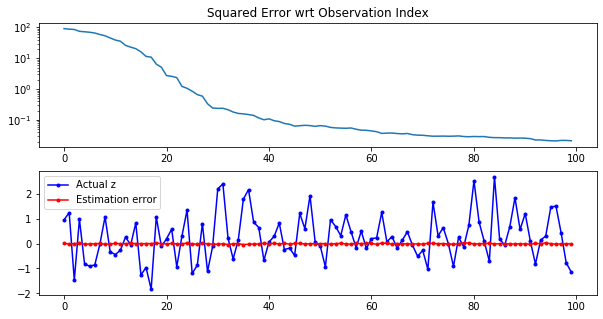

In [7]:
fig, ax = plt.subplots(2,1,figsize = (10,5))
ax[0].plot(error)
ax[0].set_yscale('log')
ax[0].set_title('Squared Error wrt Observation Index')
ax[1].plot(z, 'b.-', label = 'Actual z')
ax[1].plot(x_mean - z, 'r.-', label = 'Estimation error')
ax[1].legend()

To monitor convergence, we can also check the eigenvalues of the covariance matrix. We expect them to be lower than their initial values.

In [8]:
eigs = np.linalg.eig(x_Cov)[0]
print('Maximum eigenvalue of the covariance matrix of x : {:.3e}'.format(np.max(eigs)))

Maximum eigenvalue of the covariance matrix of x : 6.524e-04


###### Ilker Bayram, ibayram@ieee.org, 2020.